Plot saved to enhanced_prediction_plot_with_corr.png


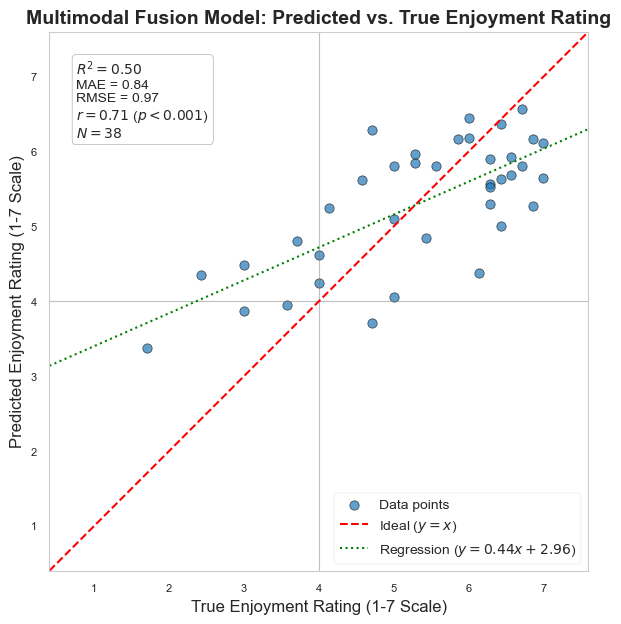

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr # Added for correlation calculation
import io # Required if reading string data

# --- Function Definition ---

def plot_predictions_vs_true_enhanced(
    true_values, predicted_values,
    title='Model Performance: Predictions vs. True Values',
    xlabel='True Values',
    ylabel='Predicted Values',
    figsize=(7, 7),
    show_regression_line=True,
    show_metrics=True,
    point_size=45,
    save_path=None,
    show_plot=True,
    style_context="seaborn-v0_8-paper",
    grid_style='whitegrid'
    ):
    """
    Creates an enhanced scatter plot for comparing predicted vs. true values,
    optimized for academic publications. Includes optional regression line and
    performance metrics (R², MAE, RMSE, Pearson r, p-value, N).

    Args:
        true_values (list, np.array, or pd.Series): The actual target values.
        predicted_values (list, np.array, or pd.Series): The values predicted by the model.
        title (str, optional): The title for the plot.
        xlabel (str, optional): The label for the x-axis.
        ylabel (str, optional): The label for the y-axis.
        figsize (tuple, optional): The figure size (width, height) in inches. Defaults to (7, 7).
        show_regression_line (bool, optional): Plot the linear regression line. Defaults to True.
        show_metrics (bool, optional): Calculate and display R², MAE, RMSE, Pearson r, p-value, N. Defaults to True.
        point_size (int, optional): Size of the scatter plot points. Defaults to 45.
        save_path (str, optional): Path to save the plot image file. Defaults to None.
        show_plot (bool, optional): Display the plot immediately. Defaults to True.
        style_context (str, optional): Seaborn style and context string. Defaults to "seaborn-v0_8-paper".
        grid_style (str, optional): Seaborn grid style. Defaults to "whitegrid".

    Returns:
        matplotlib.axes._axes.Axes: The Axes object of the plot for further customization if needed.
                                    Returns None if plotting is skipped.

    Requires: matplotlib, numpy, pandas (for example usage), seaborn, scikit-learn, scipy
    """
    # Ensure inputs are array-like and have the same length
    try:
        true_vals_arr = np.array(true_values).flatten()
        pred_vals_arr = np.array(predicted_values).flatten()
    except Exception as e:
        raise TypeError(f"Inputs must be convertible to numpy arrays. Error: {e}")

    if len(true_vals_arr) != len(pred_vals_arr):
        raise ValueError("Input arrays 'true_values' and 'predicted_values' must have the same length.")
    if len(true_vals_arr) < 2: # Need at least 2 points for correlation
        print("Warning: Need at least 2 data points to calculate correlation. Skipping metrics.")
        show_metrics = False # Force metrics off if not enough data
    if len(true_vals_arr) == 0:
        print("Warning: Input arrays are empty. Cannot generate plot.")
        return None


    # Apply Seaborn styling
    with plt.style.context(style_context):
        sns.set_style(grid_style)
        fig, ax = plt.subplots(figsize=figsize)

         # 1) Disable all Seaborn/matplotlib gridlines
        ax.grid(False)

        # 2) Compute the central x and y positions
        #    (if you want them at the midpoint of your plotted range)
        central_x = 4
        central_y = 4

        # 3) Draw just the two “gridlines” you want
        ax.axhline(y=central_y,
                color='gray',
                alpha=0.5,
                linewidth=0.8,
                label='_nolegend_')  # prevent from appearing in legend
        ax.axvline(x=central_x,
                color='gray',
                alpha=0.5,
                linewidth=0.8,
                label='_nolegend_')

        # Scatter plot
        ax.scatter(true_vals_arr, pred_vals_arr, alpha=0.7, edgecolors='k', s=point_size, linewidth=0.5, label='Data points')

        # Determine plot limits
        min_val = 1
        max_val = 7
        range_val = max_val - min_val
        buffer = range_val * 0.1 if range_val > 0 else 0.1 # Handle case where all points are identical
        lim_low = min_val - buffer
        lim_high = max_val + buffer

        # Ideal line (y=x)
        ax.plot([lim_low, lim_high], [lim_low, lim_high], 'r--', lw=1.5, label='Ideal ($y=x$)')

        # Regression line for predictions
        if show_regression_line and len(true_vals_arr) >= 2: # Check points for polyfit
             # Check if true values are constant, polyfit might warn/fail
            if np.all(true_vals_arr == true_vals_arr[0]):
                 print("Warning: True values are constant, cannot compute meaningful regression line.")
            else:
                m, c = np.polyfit(true_vals_arr, pred_vals_arr, 1)
                reg_x_vals = np.array([lim_low, lim_high])
                reg_y_vals = m * reg_x_vals + c
                ax.plot(reg_x_vals, reg_y_vals, color='green', linestyle=':', linewidth=1.5,
                        label=f'Regression ($y={m:.2f}x + {c:.2f}$)')

        # Performance Metrics Text
        if show_metrics: # Will be False if len < 2
            mae = mean_absolute_error(true_vals_arr, pred_vals_arr)
            rmse = np.sqrt(mean_squared_error(true_vals_arr, pred_vals_arr))
            r2 = r2_score(true_vals_arr, pred_vals_arr)
            n_points = len(true_vals_arr)

            # Calculate Pearson correlation and p-value
            # Handle potential constant input warning/error from pearsonr
            if np.all(true_vals_arr == true_vals_arr[0]) or np.all(pred_vals_arr == pred_vals_arr[0]):
                 r, p_val = (np.nan, np.nan) # Assign NaN if data is constant
                 print("Warning: Data is constant in at least one dimension. Cannot compute Pearson correlation.")
                 r_text = "$r = \\mathrm{NaN}$" # Use NaN text
                 p_text = "$p = \\mathrm{NaN}$"
            else:
                r, p_val = pearsonr(true_vals_arr, pred_vals_arr)
                r_text = f"$r = {r:.2f}$" # LaTeX r
                # Format p-value
                if p_val < 0.001:
                    p_text = "$p < 0.001$" # LaTeX p
                else:
                    p_text = f"$p = {p_val:.3f}$" # LaTeX p

            metrics_text = (f'$R^2 = {r2:.2f}$\n'
                            f'MAE = {mae:.2f}\n'
                            f'RMSE = {rmse:.2f}\n'
                            f'{r_text} ({p_text})\n' # Combined r and p-value
                            f'$N = {n_points}$')

            # Place text in the top-left corner
            ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes, fontsize=10,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.6, ec='grey', lw=0.5))

        # Labels, Title, Limits, Aspect Ratio
        ax.set_xlabel(xlabel, fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_xlim(lim_low, lim_high)
        ax.set_ylim(lim_low, lim_high)
        ax.set_aspect('equal', adjustable='box')

        # Legend
        ax.legend(fontsize=10, loc='lower right')

        # Save or Show Plot
        if save_path:
            try:
                plt.savefig(save_path, bbox_inches='tight', dpi=300)
                print(f"Plot saved to {save_path}")
            except Exception as e:
                print(f"Error saving plot: {e}")

        if show_plot:
            plt.show()
        else:
            plt.close(fig)

        return ax

# --- Example Usage (Identical to previous, but will now show r and p) ---

try:
    # --- IMPORTANT: Provide meaningful labels for your specific data! ---
    YOUR_VARIABLE_NAME = "Enjoyment Rating" # Replace with your actual variable
    YOUR_VARIABLE_SCALE = "(1-7 Scale)" # Replace with units or scale info
    YOUR_MODEL_NAME = "Multimodal Fusion Model" # Replace with your model's name

    # Load data
    csv_path = 'fused_predictions_avg.csv' # Make sure this file exists
    df = pd.read_csv(csv_path)

    # Extract columns (Make sure column names match your CSV)
    true_vals = df['True Values']
    pred_vals = df['Fused Predictions (Average)'] # Adjust if column name is different

    # Call the enhanced function
    plot_predictions_vs_true_enhanced(
        true_vals, pred_vals,
        title=f'{YOUR_MODEL_NAME}: Predicted vs. True {YOUR_VARIABLE_NAME}',
        xlabel=f'True {YOUR_VARIABLE_NAME} {YOUR_VARIABLE_SCALE}',
        ylabel=f'Predicted {YOUR_VARIABLE_NAME} {YOUR_VARIABLE_SCALE}',
        show_regression_line=True,
        show_metrics=True,
        save_path='enhanced_prediction_plot_with_corr.png', # New save path example
        show_plot=True
    )

except FileNotFoundError:
    print(f"Error: Make sure '{csv_path}' is in the correct directory.")
except KeyError as e:
    print(f"Error: Column {e} not found in the CSV. Check column names.")
except ImportError:
     print("Error: Missing required libraries. Ensure matplotlib, pandas, numpy, seaborn, scikit-learn, and scipy are installed.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")